In [1]:
import pandas as pd
import datetime as dt
from pandas.core.frame import DataFrame
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import watermark
from collections import namedtuple

from pathlib import Path
print(
    watermark.watermark(iversions=True, python=True,
                        machine=True, globals_=globals())
)

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

Compiler    : GCC 14.1.1 20240622
OS          : Linux
Release     : 6.9.4-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 7940HS w/ Radeon 780M Graphics
CPU cores   : 16
Architecture: 64bit

watermark : 2.4.3
numpy     : 1.26.4
matplotlib: 3.9.0
requests  : 2.31.0
pandas    : 2.2.2
seaborn   : 0.13.2



In [2]:
lang_dict = {
    "C": "C/C++",
    "C++": "C/C++",
    "Delphi/Object Pascal": "Delphi/Pascal",
    "MATLAB": "Matlab",
    "Cobol": "COBOL",
    # "VBA": "Visual Basic",
    "Powershell": "PowerShell",
    "VBScript": 'VBA/VBS',
    "VBA": "VBA/VBS",
    "ABAP": "Abap",
}

In [3]:
tiobe_url = "https://www.tiobe.com/tiobe-index/"


def get_tiobe_rank(url: str) -> DataFrame:
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        # Найти таблицу с индексом TIOBE по ее структуре или каким-то уникальным признакам
        # Это пример и может потребоваться адаптация
        table_class = "table table-striped table-top20"
        table = soup.find("table", {"class": table_class})
        rows = table.find_all("tr")

        ratings = []
        for row in rows[1:]:  # Пропустить заголовок таблицы
            # print(row)
            cols = row.find_all("td")
            # Извлечь необходимые данные из столбцов
            if len(cols) > 3:
                rank = int(cols[0].text.strip())
                lang = cols[4].text.strip()
                share = float(cols[5].text.replace("%", "").strip())
                trend = float(cols[6].text.replace("%", "").strip())
                ratings.append(
                    {"rank": rank, "lang": lang, "share": share, "trend": trend}
                )

        table = soup.find("table", {"id": "otherPL"})
        rows = table.find_all("tr")

        for row in rows[1:]:  # Пропустить заголовок таблицы
            # print(row)
            cols = row.find_all("td")
            # Извлечь необходимые данные из столбцов
            if len(cols) > 2:
                rank = int(cols[0].text.strip())
                lang = cols[1].text.strip()
                share = float(cols[2].text.replace("%", "").strip())
                trend = None
                ratings.append(
                    {"rank": rank, "lang": lang, "share": share, "trend": trend}
                )

    else:
        print("Не удалось получить данные с сайта TIOBE.")

    tiobe_rank = pd.DataFrame(ratings)
    tiobe_rank = tiobe_rank.replace(
        lang_dict).groupby("lang").sum().reset_index()
    return tiobe_rank


tiobe_rank = get_tiobe_rank(tiobe_url)
tiobe_rank

,lang,rank,share,trend
0,(Visual) FoxPro,30,0.57,0.00
1,Abap,40,0.33,0.00
2,Ada,25,0.80,0.00
3,Assembly language,13,1.26,-0.03
4,Awk,48,0.27,0.00
5,Bash,43,0.32,0.00
6,C#,5,6.65,-0.06
7,C/C++,5,19.26,-4.47
8,COBOL,20,0.96,0.22
9,Classic Visual Basic,28,0.62,0.00


In [4]:
def get_pypl_rank(url: str) -> DataFrame:
    # URL индекса популярности PYPL

    # Отправляем HTTP запрос и получаем результат
    response = requests.get(url)
    response.raise_for_status()  # Вызовет исключение, если запрос не успешен

    start_word = "<!-- begin section All-->"
    end_word = "<!-- end section All-->"
    start_idx = response.text.find(start_word) + len(start_word)
    end_idx = response.text.find(end_word)
    # Парсим HTML с помощью BeautifulSoup
    soup = BeautifulSoup(
        f"<tr>{response.content[start_idx:end_idx]}", "html.parser")
    rows = soup.find_all("tr")
    # Извлекаем данные о языках программирования и их доле
    ratings = []
    for row in rows:
        columns = row.find_all("td")
        rank = columns[0].text.strip()
        lang = columns[2].text.strip()
        share = float(columns[3].text.replace("%", "").strip())
        trend = float(columns[4].text.replace("%", "").strip())
        ratings.append({"rank": rank, "lang": lang,
                       "share": share, "trend": trend})
    df = pd.DataFrame(ratings)
    df.replace(lang_dict, inplace=True)
    return df


pypl_url = "https://pypl.github.io/PYPL.html"
# Получаем и выводим рейтинг языков программирования
pypl_rank = get_pypl_rank(pypl_url)
pypl_rank

,rank,lang,share,trend
0,1,Python,29.35,1.5
1,2,Java,15.60,-0.2
2,3,JavaScript,8.49,-0.8
3,4,C#,6.90,0.1
4,5,C/C++,6.37,-0.1
5,6,R,4.73,0.3
6,7,PHP,4.49,-0.5
7,8,TypeScript,2.96,-0.1
8,9,Swift,2.78,0.2
9,10,Rust,2.55,0.4


In [5]:
rank_all = pd.merge(
    tiobe_rank, pypl_rank, on="lang", how="outer", suffixes=("_tiobe", "_pypl")
)
rank_all['trend_norm'] = np.sqrt(rank_all.fillna(
    0)['trend_tiobe']**2+rank_all.fillna(0)['trend_pypl']**2)
rank_all

,lang,rank_tiobe,share_tiobe,trend_tiobe,rank_pypl,share_pypl,trend_pypl,trend_norm
0,(Visual) FoxPro,30.0,0.57,0.00,NaN,NaN,NaN,0.000000
1,Abap,40.0,0.33,0.00,23,0.50,-0.1,0.100000
2,Ada,25.0,0.80,0.00,17,0.96,-0.1,0.100000
3,Assembly language,13.0,1.26,-0.03,NaN,NaN,NaN,0.030000
4,Awk,48.0,0.27,0.00,NaN,NaN,NaN,0.000000
5,Bash,43.0,0.32,0.00,NaN,NaN,NaN,0.000000
6,C#,5.0,6.65,-0.06,4,6.90,0.1,0.116619
7,C/C++,5.0,19.26,-4.47,5,6.37,-0.1,4.471118
8,COBOL,20.0,0.96,0.22,25,0.15,-0.1,0.241661
9,Classic Visual Basic,28.0,0.62,0.00,NaN,NaN,NaN,0.000000


In [6]:
short_rank_all = rank_all.dropna(subset=["rank_tiobe", "rank_pypl"], how="any")

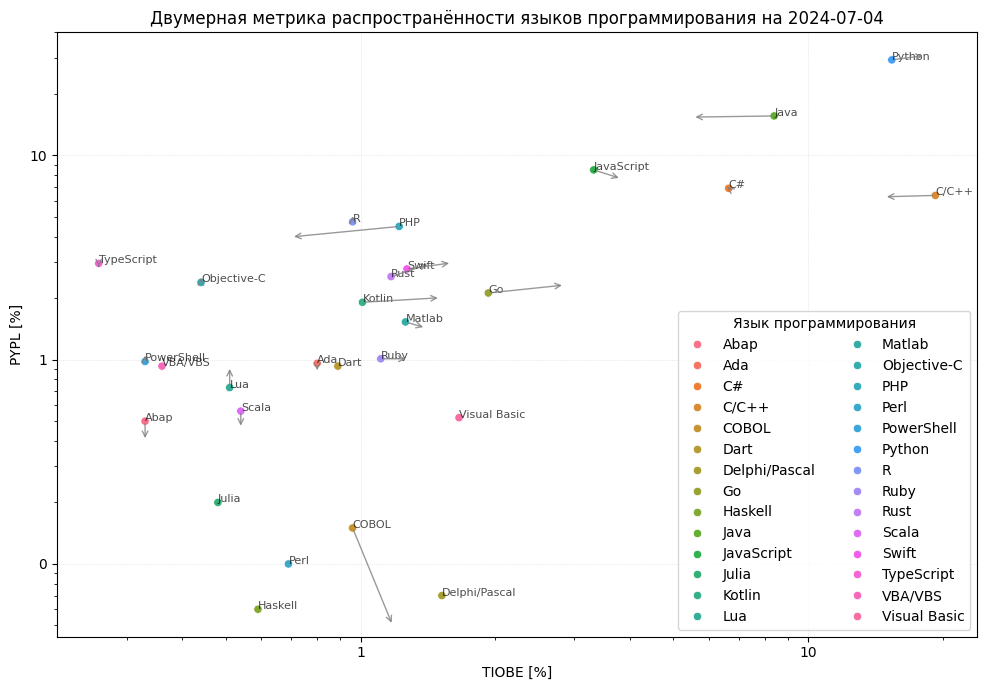

In [7]:
def norm(a, b) -> float:
    return (a**2 + b**2)**(1/2)


fig = plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=short_rank_all, x="share_tiobe",
                     y="share_pypl", hue="lang")
plt.xscale("log")
plt.yscale("log")
ax.set(
    xlabel="TIOBE [%]",
    ylabel="PYPL [%]",
    title=f"Двумерная метрика распространённости языков программирования на {
        dt.date.today()}",
    # xlim=(0, 50),
    # ylim=(0, 50),
)
ax.grid(ls=":", lw=0.5, alpha=0.5)
for x in short_rank_all.dropna().itertuples():
    ax.text(x.share_tiobe, x.share_pypl, x.lang, fontsize=8, alpha=0.7)
    if (x.trend_tiobe is not None) and (x.trend_pypl is not None) and x.trend_norm > 0.0:
        ax.annotate(
            "",
            xy=(x.trend_tiobe + x.share_tiobe, x.trend_pypl + x.share_pypl),
            xytext=(x.share_tiobe, x.share_pypl),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8, color="grey"),
        )
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc="lower right", ncol=2, title="Язык программирования")
fig.tight_layout()
fig.savefig(Path("output.png"), dpi=300)